In [1]:
import pandas as pd
import geopandas as gpd
import cartopy.crs as ccrs

import numpy as np
import matplotlib.pyplot as plt

import xarray as xr

from scipy.stats import gamma, norm, lognorm, uniform, kstest
from scipy.spatial import cKDTree
from scipy import signal

import arviz as az
import pymc as pm

from tqdm.notebook import tqdm

import sys
sys.path.append("../src")

from data.GDGT_datasets import load_duncan2023, load_rattanasriampaipong2022

# Helper function(s)

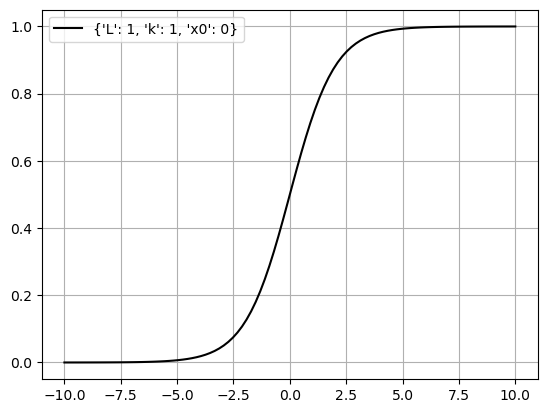

In [2]:
# Logistic curve
def logistic(x,L,k,x0):
    return L/(1+np.exp(-k*(x-x0)))

x = np.linspace(-10,10,100)
fig, ax = plt.subplots(1,1)
p = {"L": 1, "k": 1, "x0": 0}
ax.plot(x,logistic(x,**p),'k-',label=str(p))
ax.legend()
ax.grid()

In [3]:
# adjusted from https://stackoverflow.com/a/60230746/1498309
def jitter_dots(dots):
    offsets = dots.get_offsets()
    jittered_offsets = offsets
    # only jitter in the x-direction
    jittered_offsets[:, 0] += np.random.uniform(-0.3, 0.3, offsets.shape[0])
    dots.set_offsets(jittered_offsets)

In [4]:
def plot_compounds(df, compound_names, sst_name, ylabel=None):
    fig, ax = plt.subplots(1,1,figsize=(10,2))
    for i, column in enumerate(compound_names):
        sst = df[sst_name]
        x = np.full((len(df), 1), i)
        y = df[column]
        dots = plt.scatter(x, y, s=10, c=sst, marker='.',alpha=1,lw=0)
        jitter_dots(dots)
    plt.xticks(range(len(compound_names)), compound_names)
    xmin, xmax = plt.xlim()
    ax.set_xlim(xmin - 0.3, xmax + 0.3)  # make some room to show the jittered dots
    ax.set_ylabel(ylabel)
    ax.set_ylim(-0.1,1.1)
    cbar = plt.colorbar()
    return fig, ax

In [5]:
fnm = "../data/external/woa23_decav91C0_t00_04.nc"
ds = xr.open_dataset(fnm,decode_times=False).squeeze(drop=True).sel(depth=slice(0,250))["t_an"]
# fnm = "../data/external/woa23_decav91C0_s00_04.nc"
# ds2 = xr.open_dataset(fnm,decode_times=False).squeeze(drop=True).sel(depth=slice(0,250))["s_an"]

ds


<xarray.DataArray 't_an' (depth: 27, lat: 720, lon: 1440)> Size: 112MB
[27993600 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 3kB -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float32 6kB -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9
  * depth    (depth) float32 108B 0.0 5.0 10.0 15.0 ... 175.0 200.0 225.0 250.0
Attributes:
    standard_name:  sea_water_temperature
    long_name:      Objectively analyzed mean fields for sea_water_temperatur...
    cell_methods:   area: mean depth: mean time: mean within years time: mean...
    grid_mapping:   crs
    units:          degrees_celsius

In [6]:
# df = pd.read_excel("../data/external/GDGTdata_Antarctica_220923.xlsx", sheet_name="iso modern cal",skiprows=1)

# modern_data = load_duncan2023(as_frame=True)
modern_data = load_rattanasriampaipong2022(as_frame=True)
df_ = modern_data.frame

compound_names = list(df_.columns[0:6].astype(str).values)
sst_name = "SST"

df_.rename(columns={"SST": "SST_orig"},inplace=True)

df_

,GDGT-0,GDGT-1,GDGT-2,GDGT-3,Crenarchaeol,Cren',Age (Ma),Longitude,Latitude,SST_orig
0,0.411959,0.078292,0.046195,0.004400,0.441156,0.017998,0.0,0.9075,-40.0032,12.202491
1,0.398760,0.075892,0.050295,0.007799,0.445555,0.021698,0.0,17.0363,-34.6213,18.399799
2,0.350800,0.078300,0.062300,0.008600,0.470500,0.029500,0.0,13.1091,-36.4956,17.877609
3,0.379200,0.054900,0.028300,0.006900,0.512100,0.018600,0.0,17.9736,-34.3263,17.311209
4,0.371637,0.071307,0.054405,0.008801,0.463146,0.030703,0.0,7.6704,-39.2945,13.566091
...,...,...,...,...,...,...,...,...,...,...
829,0.078092,0.037196,0.107389,0.021098,0.656434,0.099790,0.0,38.7220,19.4580,28.980209
830,0.074700,0.036700,0.101600,0.019400,0.662200,0.105400,0.0,39.0530,19.1350,29.131990
831,0.080800,0.042200,0.102800,0.018600,0.656400,0.099200,0.0,39.0570,18.6020,29.237310
832,0.090400,0.043000,0.098300,0.019500,0.658300,0.090500,0.0,40.0220,17.3620,29.332390


In [7]:
# Assign WOA SST values

woa_ssts = []
for name, row in tqdm(df_.iterrows()):
    lon0, lat0 = row[["Longitude","Latitude"]].values
    this_sst = ds.interp(lon=lon0, lat=lat0, depth=0, method="nearest").values
    woa_ssts.append(this_sst)
    
df_[sst_name] = woa_ssts

df_ = df_.dropna(axis=0)

df_

0it [00:00, ?it/s]

,GDGT-0,GDGT-1,GDGT-2,GDGT-3,Crenarchaeol,Cren',Age (Ma),Longitude,Latitude,SST_orig,SST
0,0.411959,0.078292,0.046195,0.004400,0.441156,0.017998,0.0,0.9075,-40.0032,12.202491,12.412009
1,0.398760,0.075892,0.050295,0.007799,0.445555,0.021698,0.0,17.0363,-34.6213,18.399799,18.56949
2,0.350800,0.078300,0.062300,0.008600,0.470500,0.029500,0.0,13.1091,-36.4956,17.877609,17.8472
3,0.379200,0.054900,0.028300,0.006900,0.512100,0.018600,0.0,17.9736,-34.3263,17.311209,17.5416
4,0.371637,0.071307,0.054405,0.008801,0.463146,0.030703,0.0,7.6704,-39.2945,13.566091,13.73509
...,...,...,...,...,...,...,...,...,...,...,...
829,0.078092,0.037196,0.107389,0.021098,0.656434,0.099790,0.0,38.7220,19.4580,28.980209,29.33491
830,0.074700,0.036700,0.101600,0.019400,0.662200,0.105400,0.0,39.0530,19.1350,29.131990,29.4729
831,0.080800,0.042200,0.102800,0.018600,0.656400,0.099200,0.0,39.0570,18.6020,29.237310,29.56339
832,0.090400,0.043000,0.098300,0.019500,0.658300,0.090500,0.0,40.0220,17.3620,29.332390,29.64581


# Thinning of spatial data with *convenience sampling bias*

## Probability-based thinning
We want to mitigate the issues associated with non-random sampling in our spatial datasets.
Probability-based thinning involves assigning selection probabilities to locations based on specific criteria and then randomly sampling based on these probabilities.
This approach helps in maintaining spatial balance and addressing issues with convenience or opportunistic sampling.

In our dataset, we have locations `Latitude` and `Longitude` that we to thin based on the distance to the nearest neighbor.
Locations with closer neighbors will have a lower probability of being selected to ensure a more uniform spatial distribution.

1. Calculate Pairwise Distances:  Compute the distance between each location and its nearest neighbor.
2. Assign Selection Probabilities: Assign higher selection probabilities to locations that are farther from their nearest neighbors.
3. Sample Locations Based on Probabilities: Use these probabilities to randomly sample locations.

## Grid-based thinning (RECOMMENDED)

For more evenly SST spacing, a good option is to set `grid_size = 0.1`.

A good alternative is to use both, spatial grid and SST spacing, and combined both to get a more homogeneous thinned dataset.

  0%|          | 0/500 [00:00<?, ?it/s]

grid_size = 0.20


,GDGT-0,GDGT-1,GDGT-2,GDGT-3,Crenarchaeol,Cren',Age (Ma),Longitude,Latitude,SST_orig,SST,grid_sst
241,0.515148,0.020598,0.005699,0.003000,0.452655,0.002900,0.0,-134.5200,-73.9400,-1.719310,-1.71491,0
228,0.541454,0.021902,0.006801,0.002400,0.424842,0.002600,0.0,-158.2700,-77.4700,-1.512410,-1.51621,1
49,0.512049,0.033097,0.012099,0.004300,0.432857,0.005599,0.0,135.1133,79.1266,-1.138800,-1.15831,2
294,0.490049,0.038304,0.015202,0.003800,0.447345,0.005301,0.0,47.8890,82.6620,-1.346410,-1.1045101,3
257,0.531847,0.036096,0.011599,0.002700,0.410959,0.006799,0.0,139.3750,-64.2850,-0.863410,-0.83111,4
...,...,...,...,...,...,...,...,...,...,...,...,...
827,0.072107,0.036804,0.101510,0.020802,0.669167,0.099610,0.0,38.0120,19.9070,28.783001,29.177309,154
523,0.231100,0.073400,0.093300,0.017000,0.536400,0.048800,0.0,101.4990,-4.1650,29.238010,29.34099,155
536,0.239324,0.065607,0.080608,0.011901,0.543254,0.059306,0.0,162.2000,0.0000,29.427090,29.61529,156
535,0.280200,0.063400,0.079100,0.012300,0.509700,0.055300,0.0,159.4000,0.0000,29.379900,29.66531,157


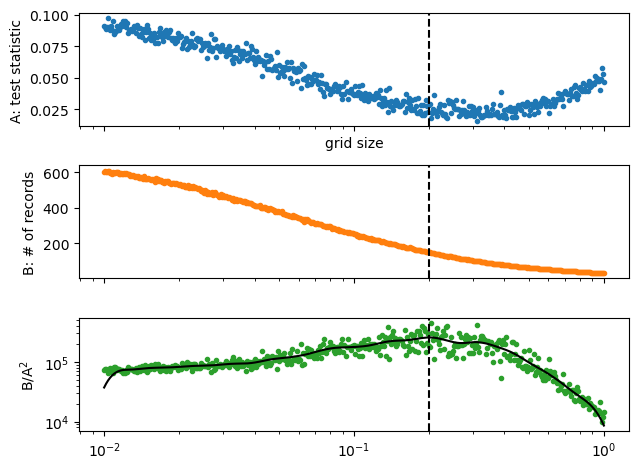

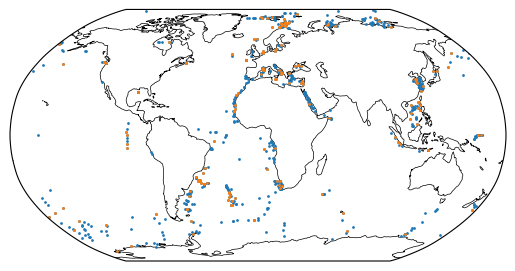

In [8]:
# # Compute pairwise distances using KDTree
# # coords = df_[['Latitude', 'Longitude', sst_name]].values
# coords = df_[[sst_name]].values
# tree = cKDTree(coords)
# distances, _ = tree.query(coords, k=2)  # k=2 to get the distance to the nearest neighbor
# df_['nearest_distance'] = distances[:, 1]  # Ignore distance to itself

# # Assign selection probabilities based on distances (inverse of distance)
# df_['selection_probability'] = df_['nearest_distance'] / df_['nearest_distance'].sum()

# # df_['selection_probability'].hist(cumulative=True,bins=100)

# # Sample locations based on selection probabilities
# desired_sample_size = len(df_)//2
# df = df_.sample(n=desired_sample_size, weights='selection_probability', random_state=42)


# grid_size = 10
# min_lat, min_lon = df_['Latitude'].min(), df_['Longitude'].min()
# df_['grid_x'] = ((df_['Latitude'] - min_lat) // grid_size).astype(int)
# df_['grid_y'] = ((df_['Longitude'] - min_lon) // grid_size).astype(int)
# # sampled_indices = df_.groupby(['grid_x', 'grid_y']).apply(lambda x: x.sample(1), include_groups=False).index.droplevel([0,1])

# fig, ax = plt.subplots(5,5,sharex=True,sharey=True)
# ax = ax.flatten()

x_ = []
y_ = []
y2_ = []

min_sst = df_[sst_name].min()

x_range = np.logspace(-2,0, 500)
# x_range = np.random.lognormal(-2,1,size=500)
for grid_size in tqdm(x_range):

    df_['grid_sst'] = ((df_[sst_name] - min_sst) // grid_size).astype(int)
    sampled_indices = df_.groupby(['grid_sst']).apply(lambda x: x.sample(1), include_groups=False).index.droplevel([0])
    df = df_.loc[sampled_indices]
    # ax[i].hist(df[sst_name],density=True,bins=np.arange(-2,33,2))
    # ax[i].set_title(f"{grid_size:.2g}",va='top',loc='left',fontsize=8)
    test = kstest(df[sst_name].astype(float).values, uniform(loc=df[sst_name].min(), scale=df[sst_name].max()-df[sst_name].min()).cdf)
    # print(f"{grid_size:.3f} {test.statistic:.3f}")
    x_.append(grid_size)
    y_.append(test.statistic)
    y2_.append(len(df))

fig, ax = plt.subplots(3,1,sharex=True)
ax[0].plot(x_,y_,ls='',marker='.',c='C0')
ax[0].set_xscale("log")
ax[0].set_xlabel("grid size")
ax[0].set_ylabel("A: test statistic")

# ax2 = ax.twinx()
ax[1].plot(x_,y2_,ls='',marker='.',c='C1')
ax[1].set_ylabel("B: # of records")

# trade-off function
# y3_ = [np.log(Y2)/(Y1) for Y1, Y2 in zip(y_,y2_)]
# y_label = r"log(B)/A"
y3_ = [Y2/(Y1**2) for Y1, Y2 in zip(y_,y2_)]
y_label = r"B/A$^2$"
ax[2].plot(x_,y3_,ls='',marker='.',c='C2')
ax[2].set_yscale("log")
ax[2].set_ylabel(y_label)

# find minimum of smoothed (i.e., filtered data points)
# win = signal.windows.gaussian(25,std=10)
win = signal.windows.hann(50)
filtered = signal.convolve(y3_, win, mode='same') / sum(win)
ax[2].plot(x_range,filtered,'k-')

# get the maximum
grid_size = np.round(x_range[np.argmax(filtered)],2)
print(f"{grid_size = :.2f}")
# grid_size = 0.25

for a in ax:
    a.axvline(grid_size,ls='--',color='k')

fig.tight_layout()

min_sst = df_[sst_name].min()
df_['grid_sst'] = ((df_[sst_name] - min_sst) // grid_size).astype(int)
sampled_indices = df_.groupby(['grid_sst']).apply(lambda x: x.sample(1), include_groups=False).index.droplevel([0])

# # combined
# sampled_indices = df_.groupby(['grid_x', 'grid_y', 'grid_sst']).apply(lambda x: x.sample(1), include_groups=False).index.droplevel([0,1,2])
df = df_.loc[sampled_indices]


# Output the sampled dataframe
display(df)


fig, ax = plt.subplots(1,1, subplot_kw={"projection": ccrs.Robinson()})
ax.coastlines(lw=0.5)
ax.set_global()

_ = ax.plot(df_["Longitude"],df_["Latitude"],ls='',marker='.',mew=0, ms=4, transform=ccrs.PlateCarree())
_ = ax.plot(df["Longitude"],df["Latitude"],ls='',marker='.',mew=0, ms=4, transform=ccrs.PlateCarree())


0it [00:00, ?it/s]

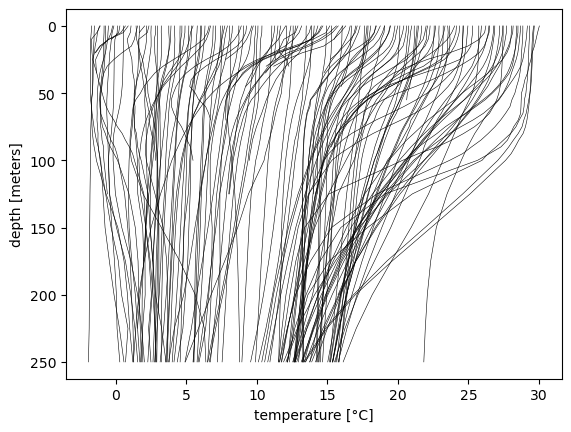

In [9]:
fig, ax = plt.subplots(1,1)

temps = []
gdgts = []

woa_data = []

for name, row in tqdm(df.iterrows()):
    lon0, lat0 = row[["Longitude","Latitude"]].values
    T_profile = ds.interp(lon=lon0, lat=lat0, method="nearest")
    woa_data.append(np.sum(~np.isnan(T_profile.values)))
    temps.append(T_profile.values)
    gdgts.append(row[compound_names].astype(float).values)
    T_profile.plot(y='depth',ax=ax,color='k',lw=0.4)
ax.invert_yaxis()
ax.set_xlabel("temperature [°C]")
df["woa_data"] = woa_data
_ = ax.set_title(None)

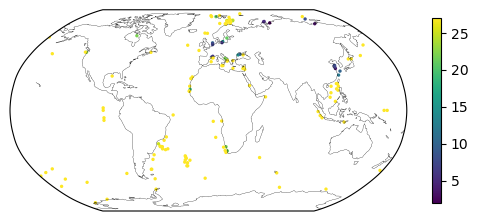

In [10]:
fig, ax = plt.subplots(1,1, subplot_kw={"projection": ccrs.Robinson()})
ax.coastlines(lw=0.2)
ax.set_global()

im = ax.scatter(df["Longitude"],df["Latitude"],c=df["woa_data"],s=2,transform=ccrs.PlateCarree())
plt.colorbar(im,ax=ax, shrink=0.5)

GDGT-0          0.515148
GDGT-1          0.020598
GDGT-2          0.005699
GDGT-3             0.003
Crenarchaeol    0.452655
Cren'             0.0029
Age (Ma)             0.0
Longitude        -134.52
Latitude          -73.94
SST_orig        -1.71931
SST             -1.71491
grid_sst               0
woa_data              27
Name: 241, dtype: object

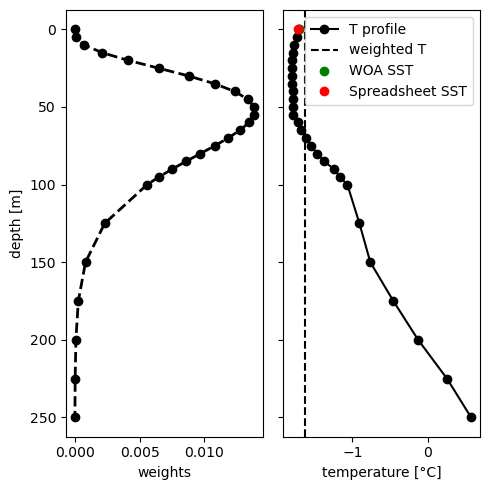

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(5,5), sharey=True)

a = 4.5
b = 15
z = ds.depth
weights = gamma.pdf(z, a, scale=b)

ax[0].plot(weights, z, 
       'ko--', lw=2, label='gamma pdf')
ax[0].invert_yaxis()
# ax[0].set_ylim(255,-5)
ax[0].set_xlabel("weights")
ax[0].set_ylabel("depth [m]")

idx = 0
display(df.iloc[idx])
ax[1].plot(temps[idx],z,'ko-',label='T profile')
valid = ~np.isnan(temps[idx])
T_avg = np.average(temps[idx][valid],weights=weights[valid]/np.sum(weights[valid]))
ax[1].axvline(T_avg,color='k',ls='--',label='weighted T')
ax[1].plot(temps[idx][0],z[0], 'go', label='WOA SST')
ax[1].plot(df.iloc[idx]["SST_orig"],z[0], 'ro', label='Spreadsheet SST')

ax[1].set_xlabel("temperature [°C]")
ax[1].legend()
fig.tight_layout()

# A functional form for GDGT distributions

- *GDGT-0*, *GDGT-1*, *GDGT-2*, *GDGT-3*, *Crenarchaeol*, *Cren'* are *Dirichlet*-distributed, with a shape parameter $a$ of length 6.
- The $a$'s depend on temperature $\hat{T}$ and follow *logistic* function (S curves) with parameters $L$, $k$, and $T_0$
  $$a_i(\hat{T}) = \frac{L_i}{(1+e^{-k_i(\hat{T}-T_{0,i})})} \quad \text{with} \quad i \in \{1,2,3,4,5,6\}$$
- Temperature $\hat{T}$ is either
  - the sea surface temperature, or
  - the depth-averaged seawater temperature with *Gamma*-distributed weights with (global) parameters $\alpha$ and $\beta$.

In [12]:
rng = np.random.default_rng(1234)

N_GDGT = 6
# L = rng.lognormal(2,1,size=N_GDGT)
# L = np.array([10,1,1,0.2,10,0.5])*20 # realistic
L = np.array([100, 13, 11, 2.5, 120, 6]) # realistic
# L = np.logspace(2,0,N_GDGT) + rng.lognormal(0,0.1,size=N_GDGT) # evenly spaced out
print(f"{L = }")

# K = rng.normal(loc=0,scale=0.02, size=N_GDGT)
# K = np.array([-0.04,0.02,0.02,0.05,0.04,0.05]) # realistic
K = np.array([-0.13, 0.016, 0.1, 0.04, -0.03, 0.09]) # realistic
# K = np.linspace(-0.1,0.1,N_GDGT) + rng.normal(loc=0,scale=0.01, size=N_GDGT) # evenly spaced out
print(f"{K = }")

# T0 = rng.normal(loc=15,scale=5,size=N_GDGT) # realistic
# T0 = np.linspace(0,30,N_GDGT) + rng.normal(loc=0,scale=1,size=N_GDGT)
# T0 = 15
T0 = 28 # realistic
T0 = np.array([16.3, 14.7, 17.3, 14.8, 15.4, 19.3]) # realistic
print(f"{T0 = }")

# T_sigma = rng.lognormal(1,2)
# T_sigma = 2
T_sigma = 0 # realistic
print(f"{T_sigma = }")

# alpha = rng.normal(loc=5,scale=2)
alpha = 4.5

print(f"{alpha = }")

# beta = rng.normal(loc=15,scale=3)
beta = 15
print(f"{beta = }")

L = array([100. ,  13. ,  11. ,   2.5, 120. ,   6. ])
K = array([-0.13 ,  0.016,  0.1  ,  0.04 , -0.03 ,  0.09 ])
T0 = array([16.3, 14.7, 17.3, 14.8, 15.4, 19.3])
T_sigma = 0
alpha = 4.5
beta = 15


In [13]:
weights = gamma.pdf(z, alpha, scale=beta)

use_sst = True

N_RECORDS = len(temps)
T_hats = []
valid_idx = []
GDGT_real = []
for idx in tqdm(range(N_RECORDS)):
    if use_sst:
        if ~np.isnan(temps[idx][0]):
            this_T_hat = temps[idx][0]
            T_hats.append(this_T_hat)
            GDGT_real.append(gdgts[idx])
    else:
        valid = ~np.isnan(temps[idx])
        if sum(valid) == len(z):
            this_T_hat = np.average(temps[idx][valid],weights=weights[valid]/np.sum(weights[valid]))
            T_hats.append(this_T_hat)
            valid_idx.append(True)
            GDGT_real.append(gdgts[idx])
        else:
            valid_idx.append(False)
    # else:
        # print(idx)
GDGT_real = np.array(GDGT_real)
print(len(T_hats))

  0%|          | 0/149 [00:00<?, ?it/s]

149


In [14]:
print(f"{np.isnan(T_hats).any() = }")
print(f"{np.isnan(GDGT_real).any() = }")

np.isnan(T_hats).any() = False
np.isnan(GDGT_real).any() = False


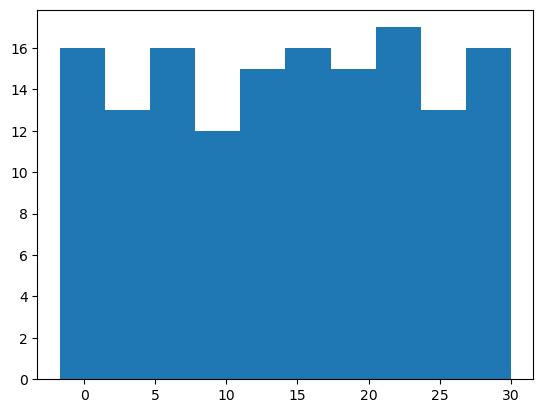

In [15]:
if use_sst:
    fig, ax = plt.subplots(1,1)
    ax.hist(T_hats)
else:
    fig, ax = plt.subplots(1,1,figsize=(15,3))
    XX, YY = np.meshgrid(np.arange(N_RECORDS)[valid_idx],z)
    Z = np.array(temps)[valid_idx].T
    print(Z.shape, len(T_hats))

    # sort by values in T_hats
    sorted_idx = np.argsort(T_hats)[::-1]

    im  = ax.pcolormesh(XX,YY,Z[:,sorted_idx])
    plt.colorbar(im,ax=ax)
    ax.invert_yaxis()

In [16]:
synthetic_proxy_names = [f"s{k}" for k in compound_names]
a = {}
for i in tqdm(range(N_GDGT)):
    this_name = synthetic_proxy_names[i]
    this_T_hats = rng.normal(T_hats,T_sigma)
    a[this_name] = logistic(this_T_hats,L[i],K[i],T0[i])


  0%|          | 0/6 [00:00<?, ?it/s]

In [17]:
df_a = pd.DataFrame(a)
# display(df_a)

# The rows in `df_a` are the shape coefficients for the *Dirichlet* distribution
synth_data = []
for _,row in df_a.iterrows():
    synth_data.append(rng.dirichlet(row.values))

df_synth = pd.DataFrame(synth_data,columns=synthetic_proxy_names)
df_synth[sst_name] = T_hats

display(df_synth)

,sGDGT-0,sGDGT-1,sGDGT-2,sGDGT-3,sCrenarchaeol,sCren',SST
0,0.445252,0.033644,0.010621,0.000146,0.507459,0.002879,-1.714910
1,0.634722,0.040746,0.003701,0.003470,0.316813,0.000549,-1.516210
2,0.572540,0.028515,0.012012,0.001512,0.383457,0.001966,-1.158310
3,0.540543,0.017350,0.001939,0.007303,0.428826,0.004039,-1.104510
4,0.490203,0.038195,0.001116,0.003031,0.466806,0.000648,-0.831110
...,...,...,...,...,...,...,...
144,0.185060,0.077873,0.073128,0.018496,0.539283,0.106159,29.177309
145,0.227732,0.043208,0.071683,0.027574,0.571179,0.058624,29.340990
146,0.166536,0.076133,0.060131,0.004556,0.655918,0.036726,29.615290
147,0.169123,0.129539,0.074139,0.000811,0.586946,0.039441,29.665310


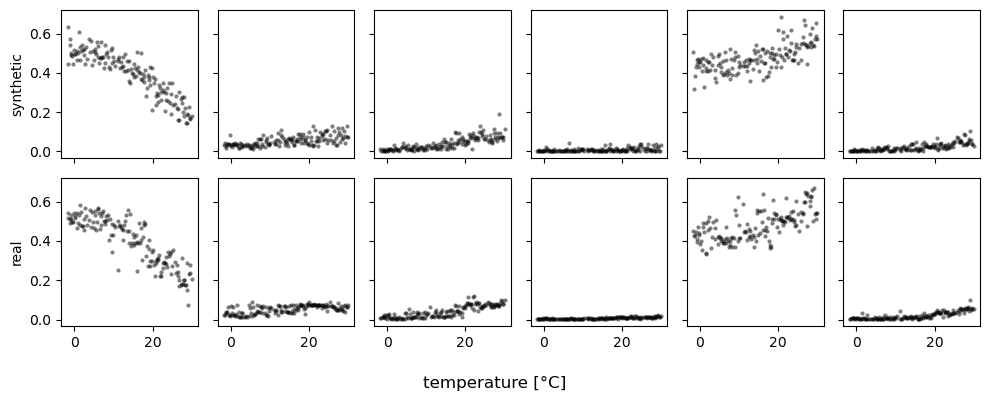

In [18]:
fig, ax = plt.subplots(2,6, sharex=True, sharey=True, figsize=(10,4))
for i in range(6):
    this_synth = synthetic_proxy_names[i]
    ax[0,i].plot(T_hats, df_synth[this_synth],'k.',mew=0, alpha=0.5)
    ax[1,i].plot(T_hats,GDGT_real[:,i],'k.',mew=0, alpha=0.5)
ax[0,0].set_ylabel("synthetic")
ax[1,0].set_ylabel("real")
fig.supxlabel("temperature [°C]")
fig.tight_layout()

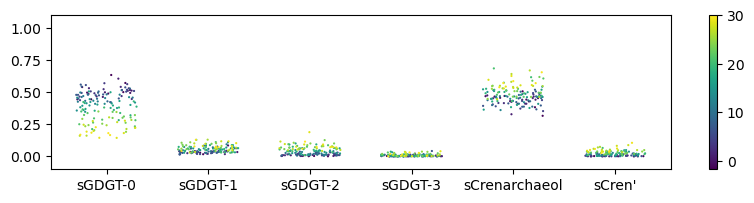

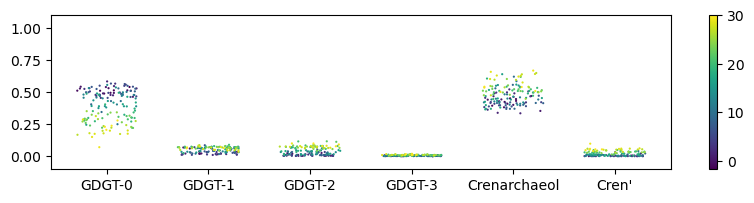

In [19]:
fig, ax = plot_compounds(df_synth, synthetic_proxy_names, sst_name)
fig, ax = plot_compounds(df, compound_names, sst_name)

# Inference of synthetic data

In [20]:
# inputs are T_hats (but will be T(z) in the future)
# outputs are GDGTs 1-6

# obs = df_synth[synthetic_proxy_names].values
observed = GDGT_real
print(observed.shape)

N_SAMPLES = 100

N_OBS = observed.shape[0]

coords = {
    "obs": np.arange(N_OBS),
    "compound": compound_names,
}
with pm.Model(coords=coords) as model:
    # priors
    L_ = pm.Lognormal("L", mu=1, sigma=2, dims="compound")
    print(f"{L_.eval() = }")

    K_ = pm.Normal("K", mu=0, sigma=0.1, dims="compound")

    T0_ = pm.Normal("T0", mu=15, sigma=3, dims="compound")
    # T0_ = pm.Normal("T0", mu=10, sigma=5)
    print(f"{T0_.eval() = }")

    # T_sigma_ = pm.HalfNormal("Tsigma", sigma=1)
    # print(f"{T_sigma_.eval() = }")

    # alpha_ = pm.Normal("alpha", mu=5, sigma=2)
    # print(f"{alpha_.eval() = }")

    # beta_ = pm.Normal("beta", mu=15, sigma=3)
    # print(f"{beta_.eval() = }")

    # T_hats_ = pm.Normal("T_hats", mu=T_hats,sigma=1, dims=("obs"))
    a_ = []
    for i in range(N_GDGT):
        a_.append(L_[i]/(1+pm.math.exp(-K_[i]*(T_hats-T0_[i]))))
    a_ = pm.Deterministic("a", pm.math.stack(a_).T, dims=("obs","compound"))
    print(f"{a_.eval().shape = }")

    GDGT_ = pm.Dirichlet("GDGT", a=a_, observed=observed, dims=("obs","compound"))
    print(f"{GDGT_.eval().shape = }")

    # Sample from prior
    idata = pm.sample_prior_predictive(samples=N_SAMPLES) 



(149, 6)


L_.eval() = array([ 1.56335222,  0.13559662, 15.29451688, 14.14489064,  1.64083266,
        1.18570422])
T0_.eval() = array([16.32028154, 15.34242966, 11.91648691, 13.2175108 , 11.90958227,
        8.59244408])
a_.eval().shape = (149, 6)
GDGT_.eval().shape = (149, 6)


Sampling: [GDGT, K, L, T0]


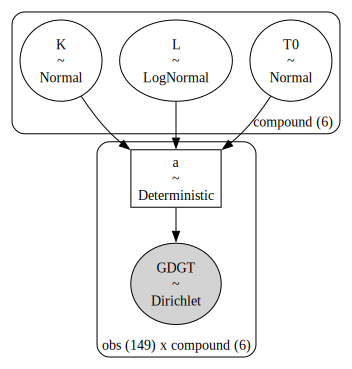

In [21]:
gv = pm.model_to_graphviz(model)
gv

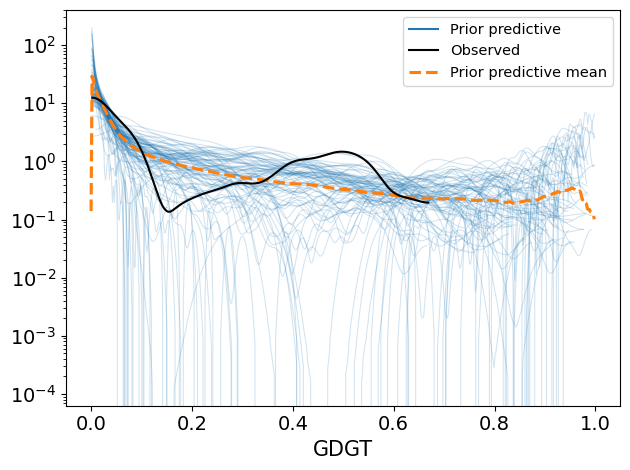

In [22]:
ax = az.plot_ppc(idata, group='prior', observed=True)
ax.set_yscale("log")
plt.tight_layout()

0 17
(149, 6)
1 74
(149, 6)
2 46
(149, 6)


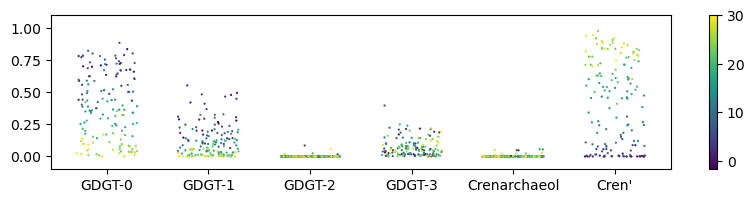

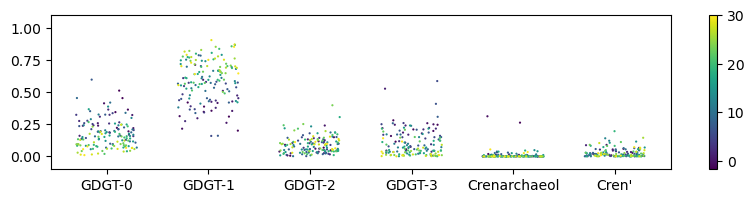

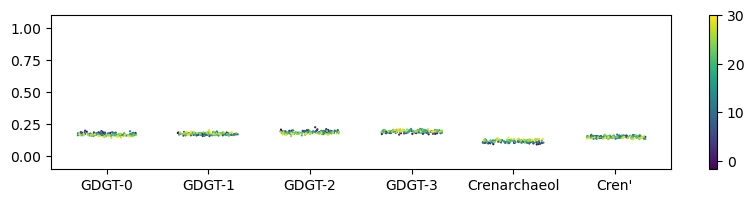

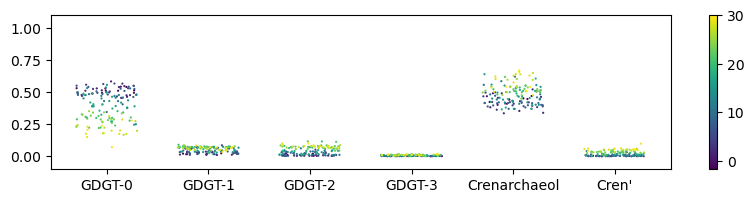

In [23]:
N = 2
for j,i in enumerate(np.random.choice(range(N_SAMPLES),N+1)):
    print(j,i)
    if j < N:
        data = idata.prior_predictive.stack(samples=("chain","draw")).isel(samples=i)
#     data = idata.prior_predictive.stack(samples=("chain","draw")).quantile(0.97,"samples")
    else:
        data = idata.prior_predictive.stack(samples=("chain","draw")).mean("samples")
    print(data["GDGT"].shape)
    df_test = pd.DataFrame(data=data["GDGT"],columns=compound_names)
    df_test[sst_name] = df_synth[sst_name]
    _, _ = plot_compounds(df_test, compound_names, sst_name)
_, _ = plot_compounds(df, compound_names, sst_name)

In [24]:
# posterior sampling
with model:
    idata.extend(pm.sample(1000, tune=2000))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [L, K, T0]


Output()

Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 99 seconds.


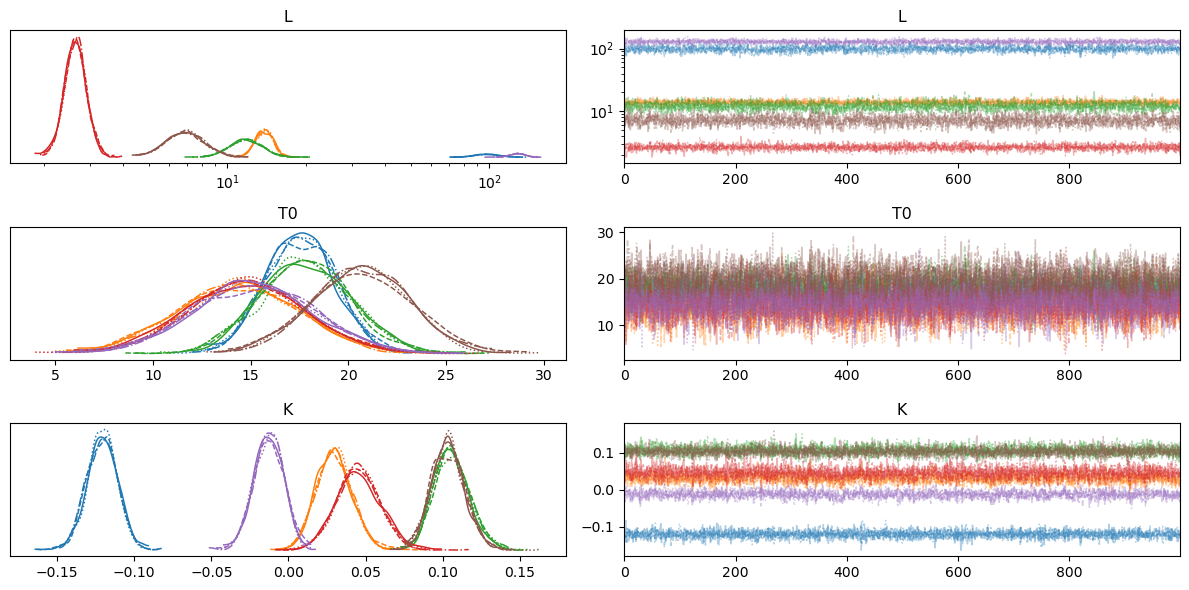

In [25]:
# var_names = ["L", "T0", "Tsigma", "K"]
var_names = ["L", "T0", "K"]

lines = (
    ('L', {}, L),
    ('T0', {}, T0),
    # ('Tsigma', {}, T_sigma),
    ('K', {}, K),
)

lines = None

ax = az.plot_trace(idata,var_names=var_names, lines=lines)
ax[0,0].set_xscale("log")
ax[0,1].set_yscale("log")
plt.tight_layout()

In [26]:
az.summary(idata,var_names=var_names)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
L[GDGT-0],99.178,10.019,80.904,117.756,0.240,0.170,1702.0,1945.0,1.0
L[GDGT-1],13.926,1.082,11.909,15.904,0.020,0.014,2959.0,2620.0,1.0
L[GDGT-2],12.110,1.693,8.922,15.103,0.035,0.025,2354.0,2589.0,1.0
L[GDGT-3],2.664,0.258,2.213,3.185,0.005,0.003,3288.0,2935.0,1.0
L[Crenarchaeol],128.669,7.938,113.635,143.162,0.145,0.103,2978.0,2519.0,1.0
L[Cren'],7.179,1.194,5.221,9.624,0.024,0.017,2550.0,2858.0,1.0
T0[GDGT-0],17.531,1.764,14.322,20.811,0.045,0.032,1525.0,2133.0,1.0
T0[GDGT-1],14.378,3.113,8.070,19.692,0.050,0.035,3870.0,2767.0,1.0
T0[GDGT-2],17.785,2.320,13.311,21.994,0.043,0.030,2920.0,2550.0,1.0
T0[GDGT-3],14.754,2.994,8.807,20.118,0.046,0.032,4289.0,2905.0,1.0


In [27]:
with model:
    idata.extend(pm.sample_posterior_predictive(idata))

Sampling: [GDGT]


Output()

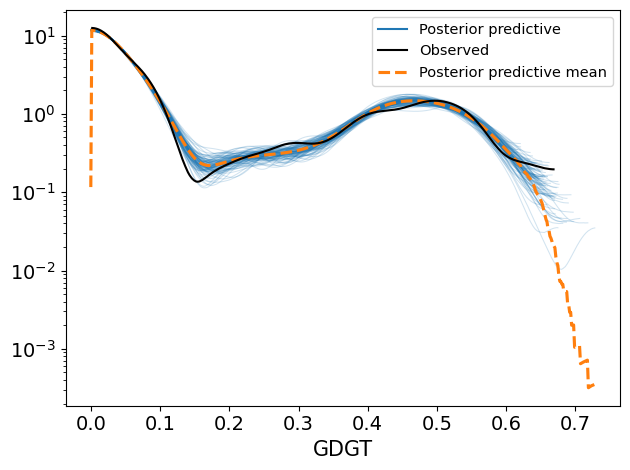

In [28]:
ax = az.plot_ppc(idata, num_pp_samples=100)
ax.set_yscale("log")
plt.tight_layout()

0 77 2
(149, 6)
1 11 2
(149, 6)
2 17 2
(149, 6)


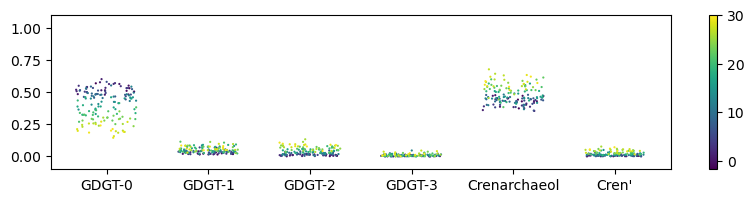

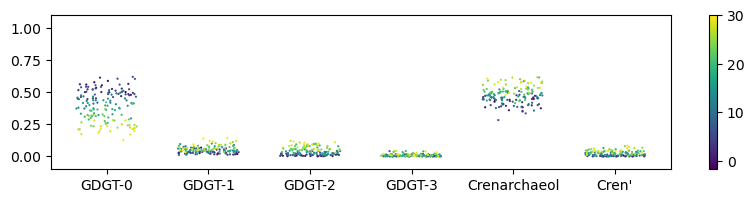

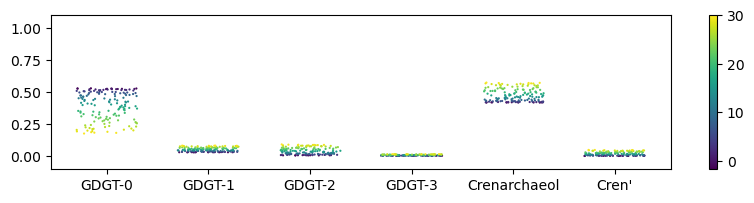

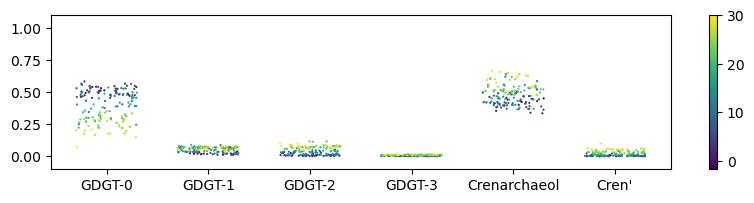

In [29]:
N = 2
for j,i in enumerate(np.random.choice(range(N_SAMPLES),N+1)):
    print(j,i,N)
    if j < N:
        data = idata.posterior_predictive.stack(samples=("chain","draw")).isel(samples=i)
    else:
        data = idata.posterior_predictive.stack(samples=("chain","draw")).mean("samples")
    print(data["GDGT"].shape)
    df_test = pd.DataFrame(data=data["GDGT"],columns=compound_names)
    df_test[sst_name] = df_synth[sst_name]
    _, _ = plot_compounds(df_test, compound_names, sst_name)
# fig, ax = plot_compounds(df_synth, synthetic_proxy_names, sst_name)
fig, ax = plot_compounds(df, compound_names, sst_name)

# Functional form of GDGT temperature dependence

Here are the functional forms of the shape parameter, $a_i(\hat{T})$, of the *Dirichlet* distribution for the 6 GDGT compounds.

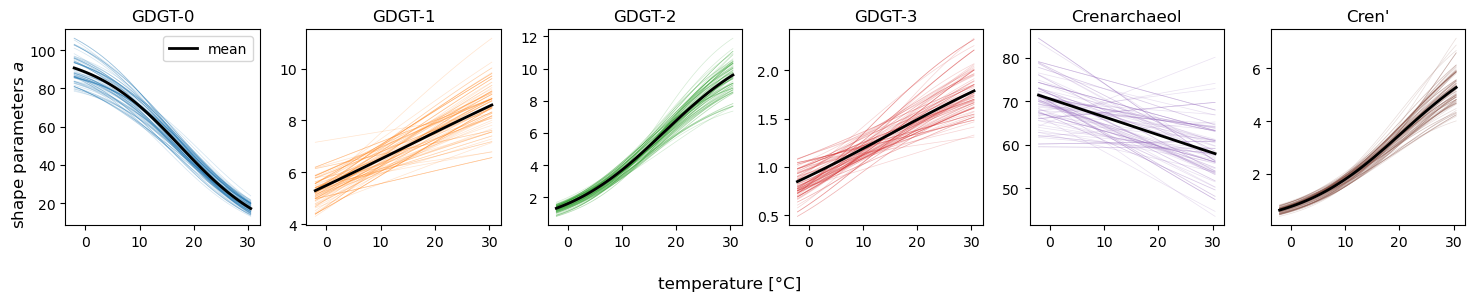

In [30]:
fig, ax = plt.subplots(1,6,figsize=(15,3),sharex=True)

sst = np.linspace(ds.min(),ds.max(),100)

N = 100
for j,i in enumerate(np.random.choice(range(N_SAMPLES),N+1)):
    # print(j,i,N)
    if j < N:
        p = np.array([idata.posterior[k].stack(samples=("chain","draw")).isel(samples=i).values for k in ["L", "K", "T0"]])
        # L_pp = idata.posterior["L"].stack(samples=("chain","draw")).isel(samples=i).values
        # K_pp = idata.posterior["k"].stack(samples=("chain","draw")).isel(samples=i).values
        # T0_pp = idata.posterior["T0"].stack(samples=("chain","draw")).isel(samples=i).values
        for k in range(N_GDGT):
            ax[k].plot(sst,logistic(sst,*p[:,k]),ls='-',color=f"C{k}", lw=0.5,alpha=0.2)
            # ax[k].plot(sst,logistic(sst,L_pp[k],K_pp[k], T0_pp),'k-',lw=1,alpha=0.1)
        # print(p.shape)
    else:
        p_median = np.array([idata.posterior[k].stack(samples=("chain","draw")).mean("samples").values for k in ["L", "K", "T0"]])
        # L_pp = idata.posterior["L"].stack(samples=("chain","draw")).mean("samples").values
        # K_pp = idata.posterior["k"].stack(samples=("chain","draw")).mean("samples").values
        # T0_pp = idata.posterior["T0"].stack(samples=("chain","draw")).mean("samples").values
        for k in range(N_GDGT):
            ax[k].plot(sst,logistic(sst,*p_median[:,k]),'k-',lw=2,label='mean')
            # ax[k].plot(sst,logistic(sst,L_pp[k],K_pp[k], T0_pp),'w-',lw=1)
        # print(p_mean.shape)

# true functions
for k in range(N_GDGT):
    ax[k].set_title(compound_names[k])
    # ax[k].plot(sst,logistic(sst,L[k], K[k], T0[k]),'r-',lw=2,label='true')
ax[0].legend()
fig.supxlabel("temperature [°C]")
fig.supylabel(r"shape parameters $a$")
fig.tight_layout()

In [31]:
with model:
    pm.compute_log_likelihood(idata)

Output()

In [32]:
az.loo(idata)

Computed from 4000 posterior samples and 149 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  2116.53    34.72
p_loo       15.84        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)      149  100.0%
   (0.70, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

GDGT-0 L lognorm (0.10661857395930129, 5.41546238114299, 93.23107991024219)
GDGT-0 K norm (-0.12089950171901788, 0.00994027178329387)
GDGT-0 T0 norm (17.531351306813317, 1.7639107140417096)
GDGT-1 L lognorm (0.05982553540704719, -4.138780049609443, 18.03272398102148)
GDGT-1 K norm (0.029749110510227255, 0.011734642283357162)
GDGT-1 T0 norm (14.377687061773663, 3.112162260801153)
GDGT-2 L lognorm (0.15409540081821424, 1.187769537912136, 10.79331817830382)
GDGT-2 K norm (0.10589896580131448, 0.011532922096714946)
GDGT-2 T0 norm (17.785057192346017, 2.319531939092395)
GDGT-3 L lognorm (0.095582480194886, -0.028647302221125652, 2.680165947247413)
GDGT-3 K norm (0.04534769372273026, 0.014268320180646056)
GDGT-3 T0 norm (14.753945455806981, 2.9940592148082956)
Crenarchaeol L lognorm (0.005409064783831115, -1338.6761178463494, 1467.3241443375346)
Crenarchaeol K norm (-0.012917239512160318, 0.00970103728617312)
Crenarchaeol T0 norm (15.110011661732935, 3.0727009917478814)
Cren' L lognorm (0.18

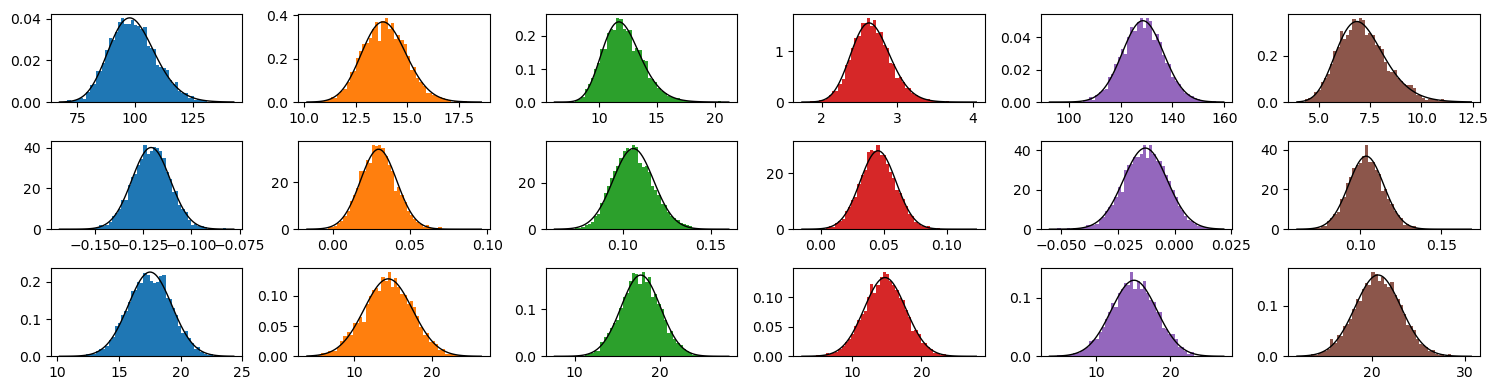

In [33]:
posterior = idata.posterior.stack(samples=("chain","draw"))
fig, ax = plt.subplots(3,6, figsize=(15,4))

dists = {"L": lognorm, "K": norm, "T0": norm}

for k in range(N_GDGT):
    for j,m in enumerate(["L", "K", "T0"]):
        this_x = posterior[m][k,:].values
        ax[j,k].hist(this_x, color=f"C{k}", bins=50, density=True)
        args = dists[m].fit(this_x)
        xmin, xmax = ax[j,k].get_xlim()
        x = np.linspace(xmin, xmax, 100)
        p = dists[m].pdf(x, *args)
        ax[j,k].plot(x, p, 'k', linewidth=1)
        print(compound_names[k], m, dists[m].__class__.__name__.split("_")[0], args)

fig.tight_layout()